<a href="https://colab.research.google.com/github/Everysimo/Muxi_SE4AI/blob/main/Muxi_BERT_IntentRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#M.U.X.I




## Setup

In [1]:
!nvidia-smi
!pip install -q -U watermark
!pip install -qq transformers
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Mon Jul 24 16:27:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc,style
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from nltk.stem import SnowballStemmer


from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import os
from six.moves import urllib

import seaborn as sb

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

###Import Dataset from GitHub

In [3]:
plt.style.use("seaborn-v0_8-whitegrid")

plt.rcParams['figure.figsize'] = (20,10)

DOWNLOAD_ROOT="https://raw.githubusercontent.com/Everysimo/Muxi_SE4AI/main/IntentsMuxyDataset.csv"

#fetch dataset da github
def fetch_file_data1(file_url1=DOWNLOAD_ROOT, file_path1="file"):
  os.makedirs(file_path1, exist_ok=True)
  csv_path1 = os.path.join(file_path1, "IntentsMuxyDataset.csv")
  urllib.request.urlretrieve(file_url1, csv_path1)
fetch_file_data1()

#df è la variabile che contiene il dataset
df=pd.read_csv("file/IntentsMuxyDataset.csv")
#df=df[["Intent", "Text"]]
df

,Intent,Text
0,0,Puoi per piacere realizzare una nuova sala col...
1,0,puoi crearmi una nuova stanza per una riunione...
2,0,"Muxi, crea una stanza per il meeting ""Discussi..."
3,0,Crea una sala riunione per 10 partecipanti e c...
4,0,Crea una sala riunione per l’incontro di doman...
...,...,...
895,2,"Muxi, puoi cambiare il contesto per renderlo p..."
896,2,Cambia il contesto in modo che sia più adatto ...
897,2,Puoi impostare un contesto adatto a una confer...
898,2,Cambia il contesto in modo che sia più adatto ...


### Data Exploration

In [4]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 76.9MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 17.4MB/s]


In [5]:
def to_sentiment(rating):
  rating = int(rating)
  return rating

df['Intent'] = df.Intent.apply(to_sentiment)
class_names = [0, 1, 2]

## Data Pre Processing

In [6]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [7]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
#Rimozione delle punteggiature
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

#Conversione in minuscolo
def to_lowercase(text):
    return text.lower()

#Rimozione delle stop words
def remove_stopwords(text):
    stop_words = set(stopwords.words('italian'))
    return " ".join([word for word in text.split() if word not in stop_words])

#Applicazione dello stemming
def apply_stemming(text):
    stemmer = SnowballStemmer("italian")
    return " ".join([stemmer.stem(word) for word in text.split()])

#Applica le funzioni di preprocessing al dataset
df["Text"] = df["Text"].apply(remove_punctuation)
df["Text"] = df["Text"].apply(to_lowercase)
df["Text"] = df["Text"].apply(remove_stopwords)
df["Text"] = df["Text"].apply(apply_stemming)

#Imposta il modello preaddestrato di BERT
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

#Tokenizzazione con BERT tokenizer
df["Tokens"] = df["Text"].apply(lambda x: tokenizer.tokenize(x))
df["Token_Ids"] = df["Tokens"].apply(lambda x: tokenizer.convert_tokens_to_ids(x))

#Visualizza il DataFrame con i risultati del preprocessing
print(df[["Text", "Text", "Tokens", "Token_Ids"]])

                                                  Text  \
0    puo piac realizz nuov sal collabor 15 partecip...   
1    puo cre nuov stanz riunion 15 person chiam riu...   
2               mux cre stanz meeting discussion modif   
3    cre sal riunion 10 partecip chiamal riunion co...   
4    cre sal riunion l’incontr doman 5 partecip nom...   
..                                                 ...   
895            mux puo camb contest rend adatt colloqu   
896                     camb contest mod adatt confert   
897                   puo impost contest adatt confert   
898                 camb contest mod adatt sal colloqu   
899                puo modific contest mod sembr class   

                                                  Text  \
0    puo piac realizz nuov sal collabor 15 partecip...   
1    puo cre nuov stanz riunion 15 person chiam riu...   
2               mux cre stanz meeting discussion modif   
3    cre sal riunion 10 partecip chiamal riunion co...   
4    cre sal 

In [9]:
sample_txt = 'Quando sono uscito l\'ultima volta?Sono chiuso in casa da due settimane.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

stop_words = set(stopwords.words('italian'))
filtered_sentence = []

for w in tokens:
    if w not in stop_words:
        filtered_sentence.append(w.lower())



print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')
print(f'Filtered_sentence: {filtered_sentence}')

 Sentence: Quando sono uscito l'ultima volta?Sono chiuso in casa da due settimane.
   Tokens: ['Q', '##uan', '##do', 'son', '##o', 'us', '##ci', '##to', 'l', "'", 'ul', '##ti', '##ma', 'vol', '##ta', '?', 'Son', '##o', 'ch', '##ius', '##o', 'in', 'ca', '##sa', 'da', 'due', 'set', '##ti', '##man', '##e', '.']
Token IDs: [154, 8734, 2572, 1488, 1186, 1366, 6617, 2430, 181, 112, 23449, 3121, 1918, 10857, 1777, 136, 6913, 1186, 22572, 3285, 1186, 1107, 11019, 3202, 5358, 1496, 1383, 3121, 1399, 1162, 119]
Filtered_sentence: ['q', '##uan', '##do', 'son', '##o', 'us', '##ci', '##to', "'", 'ul', '##ti', '##ma', 'vol', '##ta', '?', 'son', '##o', 'ch', '##ius', '##o', 'ca', '##sa', 'due', 'set', '##ti', '##man', '##e', '.']


###Tokenizer

In [10]:
tokenizer.sep_token, tokenizer.sep_token_id
tokenizer.cls_token, tokenizer.cls_token_id
tokenizer.pad_token, tokenizer.pad_token_id
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

Encoding

In [11]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


32


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


tensor([  101,   154,  8734,  2572,  1488,  1186,  1366,  6617,  2430,   181,
          112, 23449,  3121,  1918, 10857,  1777,   136,  6913,  1186, 22572,
         3285,  1186,  1107, 11019,  3202,  5358,  1496,  1383,  3121,  1399,
         1162,   102])

In [12]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])

In [13]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Q',
 '##uan',
 '##do',
 'son',
 '##o',
 'us',
 '##ci',
 '##to',
 'l',
 "'",
 'ul',
 '##ti',
 '##ma',
 'vol',
 '##ta',
 '?',
 'Son',
 '##o',
 'ch',
 '##ius',
 '##o',
 'in',
 'ca',
 '##sa',
 'da',
 'due',
 'set',
 '##ti',
 '##man',
 '##e',
 '[SEP]']

### Choosing sequence Length

In [14]:
token_lens = []

for txt in df.Text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

In [16]:
MAX_LEN = 160

In [15]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [17]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train

,Intent,Text,Tokens,Token_Ids
346,1,puo fiss nuov meeting team design revision pro...,"[pu, ##o, fi, ##ss, n, ##uo, ##v, meeting, tea...","[23609, 1186, 20497, 3954, 183, 11848, 1964, 2..."
545,1,programm meeting team ricerc svilupp gioved 10...,"[program, ##m, meeting, team, rice, ##rc, s, #...","[1788, 1306, 2309, 1264, 7738, 19878, 188, 156..."
800,2,mux puo camb lambient colloqu,"[m, ##ux, pu, ##o, ca, ##mb, la, ##mb, ##ient,...","[182, 5025, 23609, 1186, 11019, 12913, 2495, 1..."
809,2,camb contest confert,"[ca, ##mb, contest, con, ##fer, ##t]","[11019, 12913, 5235, 14255, 6732, 1204]"
778,2,camb contest rend adatt sal collabor,"[ca, ##mb, contest, re, ##nd, ad, ##att, sa, #...","[11019, 12913, 5235, 1231, 3276, 8050, 19934, ..."
...,...,...,...,...
106,0,muxy cre sal webin format,"[m, ##ux, ##y, c, ##re, sa, ##l, web, ##in, fo...","[182, 5025, 1183, 172, 1874, 21718, 1233, 5127..."
270,0,puo cre stanz 25 person chiam riunion mensil f...,"[pu, ##o, c, ##re, s, ##tan, ##z, 25, person, ...","[23609, 1186, 172, 1874, 188, 5108, 1584, 1512..."
860,2,puo impost ambient confert,"[pu, ##o, imp, ##ost, ambient, con, ##fer, ##t]","[23609, 1186, 24034, 15540, 20068, 14255, 6732..."
435,1,mux fiss incontr client doman mattin 930,"[m, ##ux, fi, ##ss, in, ##con, ##tr, client, d...","[182, 5025, 20497, 3954, 1107, 7235, 18062, 72..."


In [18]:
df_train.shape, df_val.shape, df_test.shape

((810, 4), (45, 4), (45, 4))

In [19]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.Text.to_numpy(),
    targets=df.Intent.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [22]:
BATCH_SIZE = 16

In [23]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [25]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Intent Classificator

In [26]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [27]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)
bert_model.config.hidden_size

768

In [28]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [29]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [30]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [31]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2314, 0.4397, 0.3290],
        [0.2576, 0.3429, 0.3995],
        [0.3506, 0.2380, 0.4115],
        [0.2279, 0.3437, 0.4284],
        [0.5635, 0.1886, 0.2479],
        [0.2453, 0.3907, 0.3640],
        [0.2583, 0.3175, 0.4241],
        [0.3822, 0.2244, 0.3934],
        [0.3856, 0.2119, 0.4024],
        [0.3361, 0.1955, 0.4684],
        [0.3278, 0.1764, 0.4959],
        [0.3598, 0.2001, 0.4402],
        [0.2164, 0.4007, 0.3829],
        [0.3017, 0.2999, 0.3984],
        [0.3345, 0.2544, 0.4111],
        [0.1495, 0.3324, 0.5181]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Training

In [32]:
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [34]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [35]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.2801059166074493 accuracy 0.9024691358024691


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.0034704317804425955 accuracy 1.0

Epoch 2/4
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.015035133137751152 accuracy 0.9962962962962962


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.0006566881590212384 accuracy 1.0

Epoch 3/4
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.001985687711139155 accuracy 0.9987654320987654


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.00046829985027822357 accuracy 1.0

Epoch 4/4
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.0005325558800798128 accuracy 1.0


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.00042135303374379873 accuracy 1.0

CPU times: user 1min 15s, sys: 2.25 s, total: 1min 17s
Wall time: 1min 28s


##Evaluation

In [36]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

0.9777777777777779

In [37]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [38]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

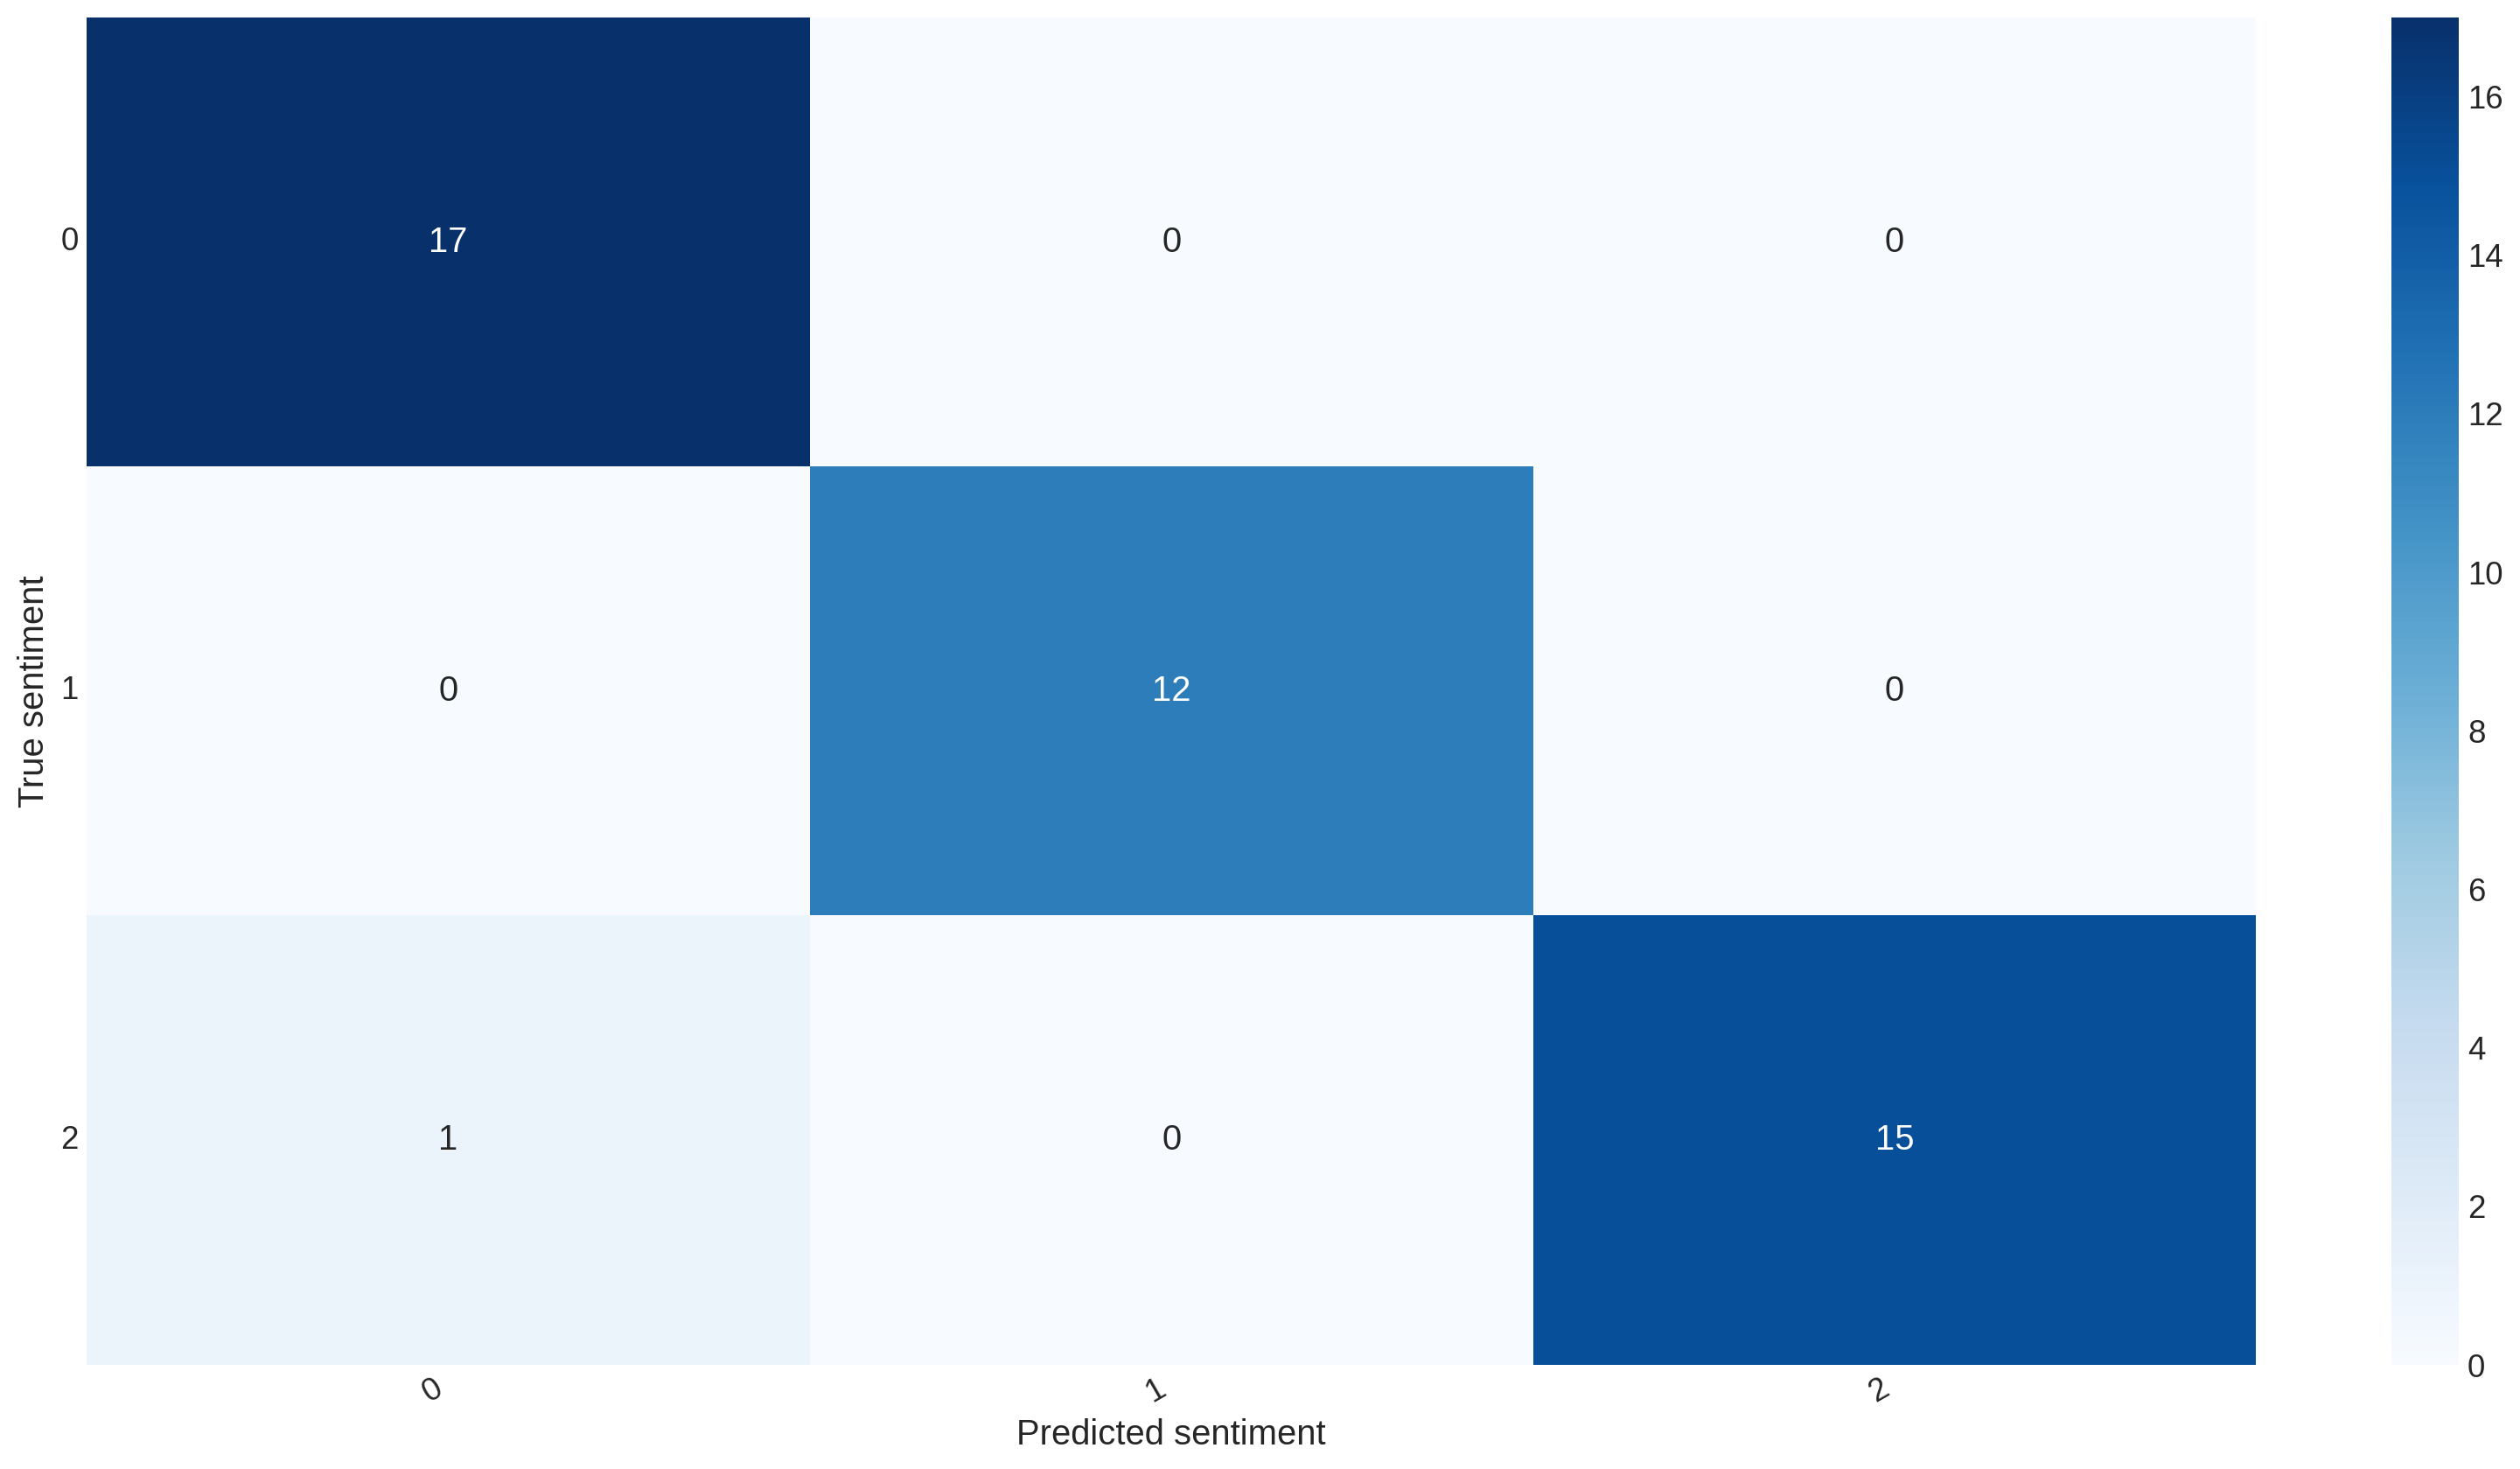

In [39]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

##Prediction

In [40]:
input_text = "Puoi creare una nuova stanza per 20 users"

encoded_review = tokenizer.encode_plus(
  input_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Input text: {input_text}')
print(f'Action  : {class_names[prediction]}')

Input text: Puoi creare una nuova stanza per 20 users
Action  : 0


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


##Save Model

In [42]:
model.cpu()
import pickle
model.type

#Salva lo stato del modello su un file pickle
with open('modelloSenzaGPU.pkl', 'wb') as f:
  pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)